In [1]:
#Projet 28
#detectron 2

import cv2
import AI
from PIL import Image
from detecterplaque import plaque
import numpy as np

cap = cv2.VideoCapture("highway.mp4")
# Object detection from Stable camera
object_detector = cv2.createBackgroundSubtractorMOG2(history=0, varThreshold=40)

marge = 10
while True:
    ret, frame = cap.read()
    height, width, _ = frame.shape
    # Extract Region of interest
    roi = frame[400: 1000,:]
    # 1. Object Detection
    mask = object_detector.apply(roi)
    _, mask = cv2.threshold(mask, 150, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
   
    for cnt in contours:
        # Calculate area and remove small elements
        area = cv2.contourArea(cnt)
        if area > 3000:
            x, y, w, h = cv2.boundingRect(cnt)
            image = cv2.cvtColor(frame[max(400+y-marge,0):min(400+y+h+marge,height),max(x-marge,0): min(x+w+marge,width)],cv2.COLOR_BGR2RGB).copy()
            plq = plaque(image)
            if not(plq is None):
                cv2.drawContours(frame,[plq + np.array([x-marge,400+y-marge])],-1, (0, 0, 255), 3)
            #cv2.imshow("Image", image)
            cv2.putText(frame, AI.reco(image), (x, 400+y - 15), cv2.FONT_HERSHEY_PLAIN, 2, (255, 0, 0), 2)
            #cv2.drawContours(roi, [cnt], -1, (0, 255, 0), 2)
            cv2.rectangle(roi, (x, y), (x + w, y + h), (0, 255, 0), 3)

    cv2.imshow("Frame", frame)    
    key = cv2.waitKey(30)
    if key == 27:
        break

cap.release()
cv2.destroyAllWindows()

number plate detected:  0
1.1428571428571428
1.1428571428571428
3.363013712774153
number plate detected:  0
4.475247524752476
number plate detected:  0
2.790256934594282
number plate detected:  0
2.063017613897823
number plate detected:  0
1.4739042415419856
number plate detected:  0
2.083750870825887
number plate detected:  0
2.095483826493036
number plate detected:  0
1.541311890475622
number plate detected:  0
1.01028783725315
number plate detected:  0
1.015633249144598
number plate detected:  0
1.7790433012008307
13.381059330256553
number plate detected:  0
3.9213604261281994
number plate detected:  0
1.0234783944757304
number plate detected:  0
1.0620506521986
number plate detected:  0
3.625801187780339
number plate detected:  0
1.0487367571803683
1.0714285714285714
2.125
number plate detected:  0
3.53334772694277
number plate detected:  0
1.2644628099173554
number plate detected:  0
3.3917843254456517
number plate detected:  0
1.2332440059948642
number plate detected:  0
1.153846

In [5]:
def imshow(image):
    while True:
        cv2.imshow("img",image)
        key = cv2.waitKey(30)
        if key == 27:
            break
    cv2.destroyAllWindows()

In [6]:
import matplotlib.pyplot as plt
import cv2

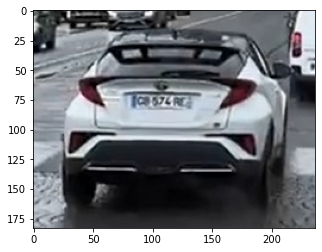

number plate detected:  0


In [8]:

lic_data = cv2.CascadeClassifier('data/haarcascade_russian_plate_number.xml')

def plt_show(image,title="",gray=False,size=(100,100)):
    temp = image
    if gray == False:
        temp = cv2.cvtColor(temp,cv2.COLOR_BGR2RGB)
        plt.title(title)
        plt.imshow(temp,cmap='gray')
        plt.show()
    
def norm(t):
    return -t[2]*t[3]

img = cv2.imread("data/car8.jpg")
#img = cv2.resize(img,(0,0),fx = 0.8,fy = 0.8)
plt_show(img)
temp = img.copy()
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
number = lic_data.detectMultiScale(img,1.2)
print("number plate detected: ",len(number))
number = sorted(number,key=norm,reverse=True)[:1]
for numbers in number:
    (x,y,w,h) = numbers
    roi_gray = gray[y:y+h,x:x+w]
    roi_color = img[y:y+h,x:x+w]
    cv2.rectangle(temp,(x,y),(x+w,y+h),(0,255,0),3)
imshow(temp)
if len(number) == 0:
    plq = img.copy()
else:
    marge = 2
    plq = img[y-marge:y+h+marge,x-marge:x+w+marge]
    

In [21]:
from detecterplaque import plaque
import imutils

image = plq
factor = 1
if image.shape[1] > 1000:
    factor = image.shape[1]/500
    image = imutils.resize(image, width=500)
img=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# RGB to Gray scale conversion
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Noise removal with iterative bilateral filter(removes noise while preserving edges)
gray = cv2.bilateralFilter(gray, 11, 17, 17)
imshow(gray)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(10, 5))
erosion = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel)
imshow(erosion)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(15, 15))
erosion2 = cv2.morphologyEx(erosion, cv2.MORPH_OPEN, kernel)
imshow(erosion2)
contrast = 255/(max(erosion2.flatten())-min(erosion2.flatten()))
contrasted = ((erosion2-min(erosion2.flatten()))*contrast).astype(np.uint8)
final = cv2.threshold(contrasted, 200, 255, cv2.THRESH_BINARY)[1]
imshow(final)
# Find Edges of the grayscale image
edged = cv2.Canny(final, 170, 200)
imshow(edged)
# Find contours based on Edges
cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[0]
cnts=sorted(cnts, key = cv2.contourArea, reverse = True)[:30] #sort contours based on their area keeping minimum required area as '30' (anything smaller than this will not be considered)
NumberPlateCnt = None #we currently have no Number plate contour

# loop over our contours to find the best possible approximate contour of number plate
count = 0
for c in cnts:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.03 * peri, True)
    if len(approx) <=4:  # Select the contour with 4 corners
        NumberPlateCnt = c #This is our approx Number Plate Contour
        x,y,w,h = cv2.boundingRect(c)
        ROI = img[y:y+h, x:x+w]
        break

cv2.drawContours(plq, [NumberPlateCnt], -1, (0,255,0), 3)
imshow(plq)

In [84]:
import numpy as np
kernel = np.ones((5,5),np.uint8)
erosion = plaque
#erosion = cv2.blur(img,(4,4))

kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(10, 5))
erosion = cv2.morphologyEx(erosion, cv2.MORPH_CLOSE, kernel)
imshow(erosion)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(15, 15))
erosion = cv2.morphologyEx(erosion, cv2.MORPH_OPEN, kernel)
imshow(erosion)


contrast = 255/(max(erosion.flatten())-min(erosion.flatten()))
erosion = ((erosion-min(erosion.flatten()))*contrast).astype(np.uint8)
erosion = cv2.threshold(erosion, 200, 255, cv2.THRESH_BINARY)[1]
imshow(erosion)

error: OpenCV(4.8.0) :-1: error: (-5:Bad argument) in function 'morphologyEx'
> Overload resolution failed:
>  - src is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'src'


In [26]:
import imutils

image = img
ratio = image.shape[0] / 500.0
orig = image.copy()


edged = cv2.Canny(erosion,75,200)

print("STEP1")
while True:
    cv2.imshow("edged",edged)
    key = cv2.waitKey(30)
    if key == 27:
        break
cv2.destroyAllWindows()

STEP1


In [27]:
contours = cv2.findContours(edged.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(contours)
contours = sorted(contours,key=cv2.contourArea,reverse=True)[:1]
screenCnt = None

for c in contours:
    peri = cv2.arcLength(c,True)
    approx = cv2.approxPolyDP(c,0.018*peri,True)
    screenCnt = approx
    break

if screenCnt is None:
    detected = 0
    print("No contour detected")
else:
    detected = 1

if detected == 1:
    cv2.drawContours(image,[screenCnt + np.array([x-marge,y-marge])],-1,(0,255,0),3)
    mask = np.zeros(gray.shape,np.uint8)
    new_image = cv2.drawContours(mask,[screenCnt + np.array([x-marge,y-marge])],0,255,-1,)
    #new_image = cv2.bitwise_and(image,image,mask=mask)

while True:
    cv2.imshow("img",image)
    key = cv2.waitKey(30)
    if key == 27:
        break
cv2.destroyAllWindows()

In [5]:
import cv2
from PIL import Image
from detecterplaque import plaque
from detecterplaque import plaquecasc
import numpy as np

cap = cv2.VideoCapture("paris.mp4")
# Object detection from Stable camera
lic_data = cv2.CascadeClassifier('data/alexnet/car.xml')

marge = 10

while True:
    ret, frame = cap.read()
    travail = frame.copy()
    height, width, _ = frame.shape
    
    # 1. Object Detection
    dimres = cv2.resize(frame,(0,0),fx = 0.5,fy = 0.5)
    gray = cv2.cvtColor(dimres,cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray,(5,5),0)
    dilated = cv2.dilate(blur,np.ones((3,3)))
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
    closing = cv2.morphologyEx(dilated, cv2.MORPH_CLOSE, kernel) 
    number = lic_data.detectMultiScale(closing,1.1)
    
    for numbers in number:
        (x,y,w,h) = 2*numbers
          # Calculate area and remove small elements
        area = w*h
        if area > 2000:
            image = travail[max(y-marge,0):min(y+h+marge,height),max(x-marge,0): min(x+w+marge,width)]
            plq = plaque(image)            
            if not(plq is None):
                cv2.drawContours(frame,[plq+np.array([x-marge,y-marge])],-1, (0, 0, 255), 3)
            #cv2.putText(frame, AI.reco(image), (x, 400+y - 15), cv2.FONT_HERSHEY_PLAIN, 2, (255, 0, 0), 2)
            #cv2.drawContours(roi, [cnt], -1, (0, 255, 0), 2)
            cv2.rectangle(frame,(x,y),(x+w,y+h),(0,255,0),3)
    
      

    cv2.imshow("Frame", frame)    
    key = cv2.waitKey(30)
    if key == 27:
        break

cap.release()
cv2.destroyAllWindows()

(183, 237, 3)
(386, 500, 3)
(216, 216, 3)
(500, 500, 3)
(106, 104, 3)
(509, 500, 3)
(120, 120, 3)
(500, 500, 3)
(130, 130, 3)
(500, 500, 3)
(216, 216, 3)
(500, 500, 3)
(120, 120, 3)
(500, 500, 3)
(106, 106, 3)
(500, 500, 3)
(266, 266, 3)
(500, 500, 3)
(144, 144, 3)
(500, 500, 3)
(210, 210, 3)
(500, 500, 3)
(190, 190, 3)
(500, 500, 3)
(256, 256, 3)
(500, 500, 3)
(130, 130, 3)
(500, 500, 3)
(110, 110, 3)
(500, 500, 3)
(226, 226, 3)
(500, 500, 3)
(124, 124, 3)
(500, 500, 3)
(106, 106, 3)
(500, 500, 3)
(272, 272, 3)
(500, 500, 3)
(222, 222, 3)
(500, 500, 3)
(138, 138, 3)
(500, 500, 3)
(180, 180, 3)
(500, 500, 3)
(276, 276, 3)
(500, 500, 3)
(108, 108, 3)
(500, 500, 3)
(220, 220, 3)
(500, 500, 3)
(120, 120, 3)
(500, 500, 3)
(134, 134, 3)
(500, 500, 3)
(174, 174, 3)
(499, 500, 3)
(110, 110, 3)
(500, 500, 3)
(144, 144, 3)
(500, 500, 3)
(198, 198, 3)
(499, 500, 3)
(270, 270, 3)
(500, 500, 3)
(278, 278, 3)
(500, 500, 3)
(124, 124, 3)
(500, 500, 3)
(170, 170, 3)
(500, 500, 3)
(316, 316, 3)
(500, 